In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")
import scienceplots

import os
import sys; sys.path.append('../')
import numpy as np
from numpy.random import default_rng

import scipy.io as sio
import pysindy as ps
from PDE_FIND import build_linear_system, print_pde, TrainSTRidge, measure_pce
from best_subset import *
from frols import frols
from UBIC import *
from solvel0 import solvel0
from findiff import FinDiff
import sgolay2

Sklearn's version: 1.6.1


#### Load data

In [2]:
n = 128
data = sio.loadmat(f"../Datasets/Big/reaction_diffusion_3d_{n}.mat")
u_sol = np.array((data['usol']).real, dtype=np.float32)
v_sol = np.array((data['vsol']).real, dtype=np.float32)
x = np.array((data['x'][0]).real, dtype=np.float32)
y = np.array((data['y'][0]).real, dtype=np.float32)
z = np.array((data['z'][0]).real, dtype=np.float32)
t = np.array((data['t'][0]).real, dtype=np.float32)

del data

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]
dz = z[1] - z[0]

# Ground truth
ground_indices_u = (0, 1, 8, 12, 18, 26)
ground_coeff_u = np.array([0.014, -0.014, -1.000, 0.020, 0.020, 0.020])
ground_indices_v = (2, 8, 13, 19, 27)
ground_coeff_v = np.array([-0.067, 1.0, 0.01, 0.01, 0.01])

In [3]:
u = np.zeros((n, n, n, len(t), 2))
u[:, :, :, :, 0] = u_sol
u[:, :, :, :, 1] = v_sol
del u_sol, v_sol

# Add noise
np.random.seed(100)
noise_lv = 0.1
domain_noise = 0.01*np.abs(noise_lv)*np.std(u)*np.random.randn(*u.shape)
u = u + domain_noise

#### Denoise

In [4]:
denoise = True
if denoise: 
    un = u[:, :, :, :, 0]
    vn = u[:, :, :, :, 1]

    div = 30
    ws = max(un.shape[:-2])//div; po = 5
    if ws%2 == 0: ws -=1

    nun = np.zeros_like(un)
    for i in trange(un.shape[-1]):
        for j in range(un.shape[-2]):
            nun[:, :, j, i] = sgolay2.SGolayFilter2(window_size=ws, poly_order=po)(un[:, :, j, i])
    un = nun.copy()
    del nun
    
    nvn = np.zeros_like(vn)
    for i in trange(vn.shape[-1]):
        for j in range(vn.shape[-2]):
            nvn[:, :, j, i] = sgolay2.SGolayFilter2(window_size=ws, poly_order=po)(vn[:, :, j, i])
    vn = nvn.copy()
    del nvn
    
    dim = 10

    un = un.reshape(-1, len(t))
    uun, sigmaun, vun = np.linalg.svd(un, full_matrices=False); vun = vun.T
    un = uun[:,0: dim].dot(np.diag(sigmaun[0:dim]).dot(vun[:,0:dim].T))
    un = un.reshape(len(x), len(y), len(z), len(t))

    vn = vn.reshape(-1, len(t))
    uvn, sigmavn, vvn = np.linalg.svd(vn, full_matrices=False); vvn = vvn.T
    vn = uvn[:,0: dim].dot(np.diag(sigmavn[0:dim]).dot(vvn[:,0:dim].T))
    vn = vn.reshape(len(x), len(y), len(z), len(t))

    u = np.stack([un, vn], axis=-1)
    del un, vn, uun, uvn

100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.02it/s]


#### Applying best-subset regression on the weak formulation

In [5]:
# optimizer = ps.SR3(threshold=1e-5, normalize_columns=True, max_iter=100)
# model = ps.SINDy(feature_library=weak_lib, optimizer=optimizer, cache=True)
# model.fit(u, ensemble=False, library_ensemble=True)
# model.print()
# X_pre, y_pre = model.feature_library.cached_xp_full[0], model.cached_x_dot

In [6]:
# Need to define the 2D spatial grid before calling the library
# X, Y, Z, T = np.meshgrid(x, y, z, t, indexing="ij")
spatiotemporal_grid = np.asarray(np.meshgrid(x, y, z, t, indexing="ij"))
spatiotemporal_grid = np.transpose(spatiotemporal_grid, axes=[1, 2, 3, 4, 0])
weak_lib = ps.WeakPDELibrary(
    function_library=ps.PolynomialLibrary(degree=3,include_bias=False),
    derivative_order=2,
    spatiotemporal_grid=spatiotemporal_grid,
    is_uniform=True,
    include_interaction=False,
    include_bias=True,
    periodic=True,
    K=5000,
)

In [7]:
# X_pre = np.array(weak_lib.fit_transform(u), dtype=np.float32)
# y_pre = np.array(weak_lib.convert_u_dot_integral(u), dtype=np.float32)
# np.save("X_pre_GS_2025.npy", X_pre)
# np.save("y_pre_GS_2025.npy", y_pre)
X_pre = np.load("X_pre_GS_2025.npy")
y_pre = np.load("y_pre_GS_2025.npy")

In [8]:
max_complexity = 12

target_index = 0
frols_coeffs,selected_inds_list,_,_,_ = frols(y_pre[:, target_index:target_index+1], X_pre, 
                                              max_nonzeros=max_complexity)
selected_inds_list = set(selected_inds_list)
ever = reduce(np.union1d, selected_inds_list)
_, bs = brute_force_all_subsets(X_pre[:, ever], 
                                y_pre[:, target_index:target_index+1], 
                                max_support_size=max_complexity)
best_subsets_u = [tuple(ever[list(b)]) for b in bs]
del bs

target_index = 1
frols_coeffs,selected_inds_list,_,_,_ = frols(y_pre[:, target_index:target_index+1], X_pre, 
                                              max_nonzeros=max_complexity)
selected_inds_list = set(selected_inds_list)
ever = reduce(np.union1d, selected_inds_list)
_, bs = brute_force_all_subsets(X_pre[:, ever], 
                                y_pre[:, target_index:target_index+1], 
                                max_support_size=max_complexity)
best_subsets_v = [tuple(ever[list(b)]) for b in bs]
del bs

100%|██████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.93it/s]


In [9]:
u_pre, v_pre = y_pre[:, 0:1], y_pre[:, 1:2]
del y_pre

#### Model selection by the UBIC (Algorithm 1)

In [10]:
tau = 3; per = 75 # 85
scale = np.log(len(u_pre))
# scale = 1

post_means, b_bics, b_uns = baye_uncertainties(best_subsets_u, (X_pre, u_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means

b_bics = np.array(b_bics)
complexities = np.array([len(bs) for bs in best_subsets_u])
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
# thres = 0.02
print(thres)

lower_bounds = []
for k, efi in enumerate(best_subsets_u):
    com = len(efi)
    assert com == np.count_nonzero(post_means[:, k:k+1])
    # lower_bound = 2*log_like_value(predictions[:, k:k+1], u_pre)/np.log(len(u_pre))-com
    lower_bound = 2*log_like_value(predictions[:, k:k+1], u_pre)-np.log(len(u_pre))*com
    lower_bounds.append(lower_bound)
    
last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(u_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam > 0:
    now_ubic = UBIC(b_bics, b_uns, len(u_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))

    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc
    
best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1

last_lam = round(last_lam, 10)
last_lam_d_u = last_lam
last_ubic_d_u = last_ubic
last_bc_d_u = last_bc
uns_u = b_uns
last_lam, last_ubic, last_bc

0.13764452422116064
5 <---> 5 inf
5 <---> 5 inf


(1.421928999,
 array([ -84546.75427496,  -82183.05349421,  -95557.7230581 ,
        -122336.85422546, -134582.56111342, -156841.45203514,
        -156717.26479712, -156700.62496012, -156693.48517299,
        -156766.11337193, -156638.99377999, -156625.82765752]),
 5)

In [11]:
tau = 3; per = 75 # 85
scale = np.log(len(v_pre))
# scale = 1

post_means, b_bics, b_uns = baye_uncertainties(best_subsets_v, (X_pre, v_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means

b_bics = np.array(b_bics)
complexities = np.array([len(bs) for bs in best_subsets_v])
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
# thres = 0.02
print(thres)

lower_bounds = []
for k, efi in enumerate(best_subsets_v):
    com = len(efi)
    assert com == np.count_nonzero(post_means[:, k:k+1])
    # lower_bound = 2*log_like_value(predictions[:, k:k+1], v_pre)/np.log(len(v_pre))-com
    lower_bound = 2*log_like_value(predictions[:, k:k+1], v_pre)-np.log(len(v_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(v_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam > 0:
    now_ubic = UBIC(b_bics, b_uns, len(v_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))

    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc
    
best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1

last_lam = round(last_lam, 10)
last_lam_d_v = last_lam
last_ubic_d_v = last_ubic
last_bc_d_v = last_bc
uns_v = b_uns
last_lam, last_ubic, last_bc

0.10625975289431372
4 <---> 4 inf
4 <---> 5 8.991454340801285e-05


(2.8548246721,
 array([ 846226.66302194, 1513824.41768947,  642360.3947097 ,
          65602.70902164, -157032.80625386, -156772.99528299,
        -156538.72978176, -154481.04578622, -154310.61753692,
        -153479.97051592, -153190.60171917, -151662.04370369]),
 4)

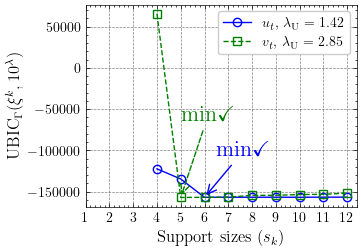

In [12]:
assert list(map(len, best_subsets_u)) == list(map(len, best_subsets_v))
complexities = list(map(len, best_subsets_u))
with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots()
    ax.plot(complexities[3:], last_ubic_d_u[3:], 'o-', c='blue', markerfacecolor='none', label="$u_t,\, \lambda_{\\textrm{U}}=$ "+str(round(last_lam_d_u, 2)))
    ax.plot(complexities[3:], last_ubic_d_v[3:], 's--', c='green', markerfacecolor='none', label="$v_t,\, \lambda_{\\textrm{U}}=$ "+str(round(last_lam_d_v, 2)))
    ax.set_xticks(complexities)
    ax.set_ylabel("$\\textrm{UBIC}_{\\Gamma}(\\xi^{k}, 10^{\\lambda})$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)

    plt.annotate('min$\checkmark$', fontsize=16, c='blue', 
             xy=(complexities[last_bc_d_u], last_ubic_d_u[last_bc_d_u]), 
             xytext=(complexities[last_bc_d_u]+0.5, last_ubic_d_u[last_bc_d_u]+0.5e5), 
             arrowprops={'arrowstyle': '->', 'linestyle':'-', 'color':'blue'})
    
    plt.annotate('min$\checkmark$', fontsize=16, c='green', 
             xy=(complexities[last_bc_d_v], last_ubic_d_v[last_bc_d_v]), 
             xytext=(complexities[last_bc_d_v], last_ubic_d_v[last_bc_d_v]+0.925e5), 
             arrowprops={'arrowstyle': '->', 'linestyle':'--', 'color':'green'})
    
    plt.legend()
    plt.show()

#### Percent coefficient error

In [13]:
assert np.alltrue(best_subsets_v[last_bc_d_v] == ground_indices_v) and np.alltrue(best_subsets_u[last_bc_d_u] == ground_indices_u)
errs_u = measure_pce(np.linalg.lstsq(X_pre[:, ground_indices_u], u_pre, rcond=None)[0].flatten(), 
                     ground_coeff_u)
errs_v = measure_pce(np.linalg.lstsq(X_pre[:, ground_indices_v], v_pre, rcond=None)[0].flatten(), 
                     ground_coeff_v)
print(errs_u.mean(), errs_u.std())
print(errs_v.mean(), errs_v.std())

0.07932984403201548 0.1376675092222184
0.002098426000397427 0.0017979140746648423
